In [1]:
import sys
import matplotlib.pyplot as plt
import time
import datetime
import numpy as np
from math import ceil

with open('viruses_hifi_sample_dates.csv', 'r') as f:
    virus_map = dict(line.rstrip().split(",") for line in f if len(line.rstrip().split(",")[1]))
    
num_sample_map = dict()
for sra, date in virus_map.items():
    if len(date) != 10:
        print(sra,date,len(sra),len(date))
    date = time.mktime(datetime.datetime.strptime(date, "%Y-%m-%d").timetuple())    
    if date not in num_sample_map:
        num_sample_map[date] = [0, 0]
    num_sample_map[date][0] += 1
    
num_samples = 7
sample_map = dict()
with open('delta_variants.fa.out.parsed.reads', 'r') as f:
    for line in f:
        line = line.rstrip().split("\t")
        idx = int(line[0])
        for match in line[2:]:
            sample, coords = match.split(":")
            sample = sample.split("/")[-2]
            if sample not in sample_map:
                sample_map[sample] = [set() for i in range(num_samples)]
            sample_map[sample][idx] = sample_map[sample][idx].union(int(a) for a in coords.split(","))
    

In [2]:
from copy import copy

date_to_sample = dict()
date_to_count = dict()
for date in num_sample_map:
    date_to_sample[date] = 0
    date_to_count[date] = 0
    num_sample_map[date][1] = 0
    
print(len(sample_map))
total = 0
for sample, coords in sample_map.items():
    if any(len(a) == 0 for a in coords):
        continue
    total += 1
        
    coord_union = copy(coords[0])
    for next_coords in coords[1:]:
        coord_union = coord_union.union(next_coords)
    a = sorted(list(coord_union),reverse=True)
    a_s = np.array(a[1:] + [-2001])
    a = np.array(a)
    b = a[a - a_s > 2000]
    date = virus_map[sample]
    date = time.mktime(datetime.datetime.strptime(date, "%Y-%m-%d").timetuple())
    date_to_count[date] += len(b)
    date_to_sample[date] += 1
    num_sample_map[date][1] += 1
date_to_sample = sorted([(a,b) for a,b in date_to_sample.items()])
date_to_count = sorted([(a,b) for a,b in date_to_count.items()])
num_sample_map_fold = sorted([(a,b) for a,b in num_sample_map.items()])
print(total)

151545
91745


0.9050864659409763


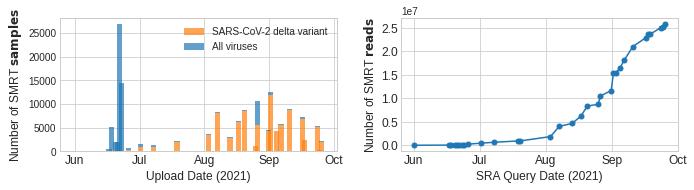

In [10]:
from math import ceil
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
})
f, axs = plt.subplots(1,2,figsize=(10,3))
fontsize=8
fontsize_big=12

month = 2629746 * 1

def fix_xlabels(ax,dates):
    num_steps = int(ceil((dates[-1]-dates[0])/month)) + 1
    xticks = [dates[0] + i * month for i in range(num_steps)]
    xticklabels = [datetime.datetime.utcfromtimestamp(a).strftime('%b') for a in xticks]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels,fontsize=fontsize_big)

for ax,data,ylabel in zip(axs[1:],
                          #[date_to_sample,date_to_count],
                          [date_to_count],
                          #["Number of SMRT samples in SRA","Number of HiFi reads in SRA"]):
                          ["Number of SMRT " + r"$\bf{reads}$"]):
    t = min([i for i,(a,(b,c)) in enumerate(num_sample_map_fold) if c > 0]) - 1
    dates = np.array([a for a,b in data[t:]])
    counts = np.array([b for a,b in data[t:]])
    fraction = np.array([c/b for a,(b,c) in num_sample_map_fold[t:]])
    counts = np.cumsum(counts)
    #ax.plot(dates,counts)
    #print(len(dates))
    #ax.bar(x=dates,height=counts,width=3)
    ax.plot(dates,counts,ms=5,marker="o")
    ax.set_xlabel("SRA Query Date (2021)",fontsize=fontsize_big)
    fix_xlabels(ax,dates)
    ax.set_ylabel(ylabel,fontsize=fontsize_big)
    plt.yticks(fontsize=fontsize_big)
    
#t = 0
t = min([i for i,(a,(b,c)) in enumerate(num_sample_map_fold) if c > 0]) - 1
total_samples = np.array([b for a,(b,c) in num_sample_map_fold[t:]])
delta_samples = np.array([c for a,(b,c) in num_sample_map_fold[t:]])
dates = np.array([a for a,b in num_sample_map_fold[t:]])
#axs[0].plot(dates,delta_samples/total_samples,ms=5,marker="o")
axs[0].bar((dates - dates[0]) / (dates[-1]-dates[0]),
           delta_samples,
           width=1/len(dates)/1.5,
           label="SARS-CoV-2 delta variant",
           alpha=0.7,color="C1")
axs[0].bar((dates - dates[0]) / (dates[-1]-dates[0]),
           total_samples-delta_samples,
           bottom=delta_samples,
           width=1/len(dates)/1.5,
           label="All viruses",
           alpha=0.7,color="C0")
num_steps = int(ceil((dates[-1]-dates[0])/month)) + 1
xticks = np.array([dates[0] + i * month for i in range(num_steps)])
print((delta_samples[dates >= xticks[1]]).sum()/ (total_samples[dates >= xticks[1]]).sum())
plot_xticks = (xticks - dates[0]) / (dates[-1]-dates[0])
axs[0].set_xticks(plot_xticks)
xticklabels = [datetime.datetime.utcfromtimestamp(a).strftime('%b') for a in xticks]
axs[0].set_xticklabels(xticklabels,fontsize=fontsize_big)
axs[0].set_ylabel("Number of SMRT " + r"$\bf{samples}$",fontsize=fontsize_big)
axs[0].set_xlabel("Upload Date (2021)",fontsize=fontsize_big)
axs[0].legend()

f.tight_layout(pad=2)
f.savefig("delta_histogram.pdf",bbox_inches='tight',pad_inches=0)